In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"
os.environ['DASHSCOPE_API_KEY'] = "xxxxxxxxxxx"
os.environ['MODELSCOPE_API_TOKEN'] = 'xxxxxxxxxxxx'

In [2]:
prompts = []
outputs = []


# 这个是python的猴子补丁(Monkey Patching) ，这里用于hook住modelscope_agent的代码，以便我们可以查看模型的input和output
def fix_1():
    import random
    import traceback
    from http import HTTPStatus
    from typing import Union

    import dashscope
    from dashscope import Generation
    from modelscope_agent.agent_types import AgentType

    from modelscope_agent.llm.base import LLM
    from modelscope_agent.llm.utils import DEFAULT_MESSAGE, CustomOutputWrapper

    class my_DashScopeLLM(LLM):
        name = 'dashscope_llm'

        def __init__(self, cfg):
            super().__init__(cfg)
            self.model = self.cfg.get('model', 'modelscope-agent-llm-v1')
            self.model_id = self.model
            self.generate_cfg = self.cfg.get('generate_cfg', {})
            self.agent_type = self.cfg.get('agent_type', AgentType.DEFAULT)

        def generate(self,
                     llm_artifacts: Union[str, dict],
                     functions=[],
                     **kwargs):
            prompts.append(llm_artifacts)

            # TODO retry and handle message
            try:
                if self.agent_type == AgentType.Messages:
                    messages = llm_artifacts if len(
                        llm_artifacts) > 0 else DEFAULT_MESSAGE
                    self.generate_cfg['use_raw_prompt'] = False
                    response = dashscope.Generation.call(
                        model=self.model,
                        messages=messages,
                        # set the random seed, optional, default to 1234 if not set
                        seed=random.randint(1, 10000),
                        result_format=
                        'message',  # set the result to be "message" format.
                        stream=False,
                        **self.generate_cfg)
                    llm_result = CustomOutputWrapper.handle_message_chat_completion(
                        response)
                else:
                    response = Generation.call(
                        model=self.model,
                        prompt=llm_artifacts,
                        stream=False,
                        **self.generate_cfg)
                    llm_result = CustomOutputWrapper.handle_message_text_completion(
                        response)
                outputs.append(llm_result)
                return llm_result
            except Exception as e:
                error = traceback.format_exc()
                error_msg = f'LLM error with input {llm_artifacts} \n dashscope error: {str(e)} with traceback {error}'
                print(error_msg)
                raise RuntimeError(error)

            if self.agent_type == AgentType.MS_AGENT:
                # in the form of text
                idx = llm_result.find('<|endofthink|>')
                if idx != -1:
                    llm_result = llm_result[:idx + len('<|endofthink|>')]
                return llm_result
            elif self.agent_type == AgentType.Messages:
                # in the form of message
                return llm_result
            else:
                # in the form of text
                return llm_result

        def stream_generate(self,
                            llm_artifacts: Union[str, dict],
                            functions=[],
                            **kwargs):
            print('stream_generate')
            prompts.append(llm_artifacts)

            total_response = ''
            try:
                if self.agent_type == AgentType.Messages:
                    self.generate_cfg['use_raw_prompt'] = False
                    responses = Generation.call(
                        model=self.model,
                        messages=llm_artifacts,
                        stream=True,
                        result_format='message',
                        **self.generate_cfg)
                else:
                    responses = Generation.call(
                        model=self.model,
                        prompt=llm_artifacts,
                        stream=True,
                        **self.generate_cfg)
            except Exception as e:
                error = traceback.format_exc()
                error_msg = f'LLM error with input {llm_artifacts} \n dashscope error: {str(e)} with traceback {error}'
                print(error_msg)
                raise RuntimeError(error)

            for response in responses:
                if response.status_code == HTTPStatus.OK:
                    if self.agent_type == AgentType.Messages:
                        llm_result = CustomOutputWrapper.handle_message_chat_completion(
                            response)
                        frame_text = llm_result['content'][len(total_response):]
                    else:
                        llm_result = CustomOutputWrapper.handle_message_text_completion(
                            response)
                        frame_text = llm_result[len(total_response):]
                    yield frame_text

                    if self.agent_type == AgentType.Messages:
                        total_response = llm_result['content']
                    else:
                        total_response = llm_result
                else:
                    err_msg = 'Error Request id: %s, Code: %d, status: %s, message: %s' % (
                        response.request_id, response.status_code, response.code,
                        response.message)
                    print(err_msg)
                    raise RuntimeError(err_msg)

    from modelscope_agent.llm import dashscope_llm
    dashscope_llm.DashScopeLLM = my_DashScopeLLM


fix_1()  # 如果不需要查看模型的input和output，可以不用执行这个cell

In [3]:
from modelscope_agent.tools import Tool
from modelscope_agent.llm import LLMFactory
from modelscope_agent.prompt import MrklPromptGenerator
from modelscope_agent.output_parser import MRKLOutputParser
from modelscope.utils.config import Config
from modelscope_agent.agent import AgentExecutor

model_name = 'qwen-max'
model_cfg = {
    "qwen-max": {
        "type": "dashscope",
        "model": "qwen-max",
        "generate_cfg": {
            "use_raw_prompt": True,
            "top_p": 0.8,
            "debug": False
        }
    },
    "modelscope-agent": {
        "type": "dashscope",
        "model": "modelscope-agent-llm-v1",
        "generate_cfg": {
            "use_raw_prompt": True,
            "top_p": 0.8,
            "seed": 666,
            "debug": False
        }
    }
}

llm = LLMFactory.build_llm(model_name, model_cfg)
prompt_generator = MrklPromptGenerator(llm=llm)
output_parser = MRKLOutputParser()


class AliyunRenewInstanceTool(Tool):
    description = '续费一台包年包月ECS实例'
    name = 'RenewInstance'
    parameters: list = [{
        'name': 'instance_id',
        'description': 'ECS实例ID',
        'required': True
    },
        {
            'name': 'period',
            'description': '续费时长以月为单位',
            'required': True
        }
    ]

    def _local_call(self, *args, **kwargs):
        instance_id = kwargs['instance_id']
        period = kwargs['period']
        return {'result': f'成功为{instance_id}续费，续费时长{period}月'}


tool_cfg = Config.from_file(r'.\cfg_tool_template.json')
additional_tool_list = {
    'RenewInstance': AliyunRenewInstanceTool()
}

agent = AgentExecutor(llm, tool_cfg=tool_cfg, additional_tool_list=additional_tool_list, tool_retrieval=False,
                      prompt_generator=prompt_generator, output_parser=output_parser)

2023-12-12 13:41:56,533 - modelscope - INFO - PyTorch version 2.1.0+cu121 Found.
2023-12-12 13:41:56,538 - modelscope - INFO - Loading ast index from C:\Users\17597\.cache\modelscope\ast_indexer
2023-12-12 13:41:56,665 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 2398d4898f13481778ca9998c4f0782a and a total number of 945 components indexed


In [4]:
agent.reset()
prompts = []
outputs = []
agent.run("请帮我续费一台ECS实例，实例id是：i-rj90a7e840y5cde，续费时长10个月", remote=False, print_info=False)

**************************************************round 1**************************************************

Thought: 我需要调用RenewInstance API 续费一台ECS实例
Action: RenewInstance
Action Input: {"instance_id": "i-rj90a7e840y5cde", "period": 10}


成功为i-rj90a7e840y5cde续费，续费时长10月

**************************************************round 2**************************************************

。
Thought: 我现在可以作答了。
Final Answer: 成功为i-rj90a7e840y5cde续费，续费时长10月。

[{'result': '成功为i-rj90a7e840y5cde续费，续费时长10月'}]

In [5]:
for i in range(len(prompts)):
    print(f'prompt:\n{prompts[i]}')
    print('*' * 20)
    print(f'output:\n{outputs[i]}')
    print('-' * 20)

prompt:
<|im_start|>user
Answer the following questions as best you can. You have access to the following tools: `

modelscope_text-address: modelscope_text-address API. 地址解析服务，针对中文地址信息，识别出里面的元素，包括省、市、区、镇、社区、道路、路号、POI、楼栋号、户室号等 输入参数: [{"name": "input", "description": "用户输入的地址信息", "required": true}]

modelscope_text-ner: modelscope_text-ner API. 命名实体识别服务，针对需要识别的中文文本，找出其中的实体，返回json格式结果 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}]

modelscope_text-ie: modelscope_text-ie API. 信息抽取服务，针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}, {"name": "schema", "description": "要抽取信息的json表示", "required": true}]

modelscope_speech-generation: modelscope_speech-generation API. 文本转语音服务，将文字转换为自然而逼真的语音，可配置男声/女声 输入参数: [{"name": "input", "description": "要转成语音的文本", "required": true}, {"name": "gender", "description": "用户身份", "required": true}]

modelscope_video-generation: modelscope_video-generation API. 视频生成服务，针对英文文本输入，生成

In [6]:
agent.reset()
prompts = []
outputs = []
# Single-step tool-use
agent.run('使用地址识别模型，从下面的地址中找到省市区等元素，地址：浙江杭州市江干区九堡镇三村村一区', remote=True,
          print_info=False)

**************************************************round 1**************************************************

Thought: 我需要使用modelscope_text-address来解析地址信息
Action: modelscope_text-address
Action Input: {"input": "浙江杭州市江干区九堡镇三村村一区"}


<IPython.core.display.JSON object>

**************************************************round 2**************************************************

 
Thought: 我已经得到了地址信息
Final Answer: 浙江省杭州市江干区九堡镇三村村一区。

[{'result': {'prov': '浙江',
   'city': '杭州市',
   'district': '江干区',
   'town': '九堡镇',
   'community': '三村村',
   'poi': '一区'}}]

In [7]:
for i in range(len(prompts)):
    print(f'prompt:\n{prompts[i]}')
    print('*' * 20)
    print(f'output:\n{outputs[i]}')
    print('-' * 20)

prompt:
<|im_start|>user
Answer the following questions as best you can. You have access to the following tools: `

modelscope_text-address: modelscope_text-address API. 地址解析服务，针对中文地址信息，识别出里面的元素，包括省、市、区、镇、社区、道路、路号、POI、楼栋号、户室号等 输入参数: [{"name": "input", "description": "用户输入的地址信息", "required": true}]

modelscope_text-ner: modelscope_text-ner API. 命名实体识别服务，针对需要识别的中文文本，找出其中的实体，返回json格式结果 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}]

modelscope_text-ie: modelscope_text-ie API. 信息抽取服务，针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}, {"name": "schema", "description": "要抽取信息的json表示", "required": true}]

modelscope_speech-generation: modelscope_speech-generation API. 文本转语音服务，将文字转换为自然而逼真的语音，可配置男声/女声 输入参数: [{"name": "input", "description": "要转成语音的文本", "required": true}, {"name": "gender", "description": "用户身份", "required": true}]

modelscope_video-generation: modelscope_video-generation API. 视频生成服务，针对英文文本输入，生成

**************************************************round 1**************************************************

Thought: 我会回答。
Final Answer: “Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！”
Action: modelscope_speech-generation
Action Input: {"input": "Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！", "gender": "女声"}


**************************************************round 2**************************************************

 
Thought: 我会回答。
Final Answer: “Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！”
Action: modelscope_video-generation
Action Input: {"text": "Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！"}


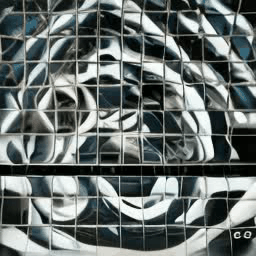

**************************************************round 3**************************************************

Thought: 我会回答。
Final Answer: “Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！”
Action: modelscope_speech-generation
Action Input: {"input": "Vision Pro VR眼镜，带你进入超现实的虚拟世界，感受身临其境的震撼体验！", "gender": "女声"}


**************************************************round 4**************************************************

[{'result': <audio id=audio controls= preload=none> <source id=wav src=C:\Users\17597\AppData\Local\Temp\tmpgp33uk62\e369a211-a050-42f7-9125-0fb3a8598337.wav> </audio>},
 {'result': ![IMAGEGEN](C:\Users\17597\AppData\Local\Temp\tmp3_ngmyw2\656c85df-ae64-4dfb-a3f8-a258acdc45e5.gif)},
 {'result': <audio id=audio controls= preload=none> <source id=wav src=C:\Users\17597\AppData\Local\Temp\tmp7cxqhdgu\28ccc33f-174a-416b-b940-0822aa6178e6.wav> </audio>}]

In [10]:
# Multi-step tool-use
agent.reset()
prompts = []
outputs = []
agent.run('写一篇关于Vision Pro VR眼镜的20字宣传文案，并用女声读出来，同时生成个视频看看', remote=True, print_info=False)

In [11]:
for i in range(len(prompts)):
    print(f'prompt:\n{prompts[i]}')
    print('*' * 20)
    print(f'output:\n{outputs[i]}')
    print('-' * 20)

prompt:
<|im_start|>user
Answer the following questions as best you can. You have access to the following tools: `

modelscope_text-address: modelscope_text-address API. 地址解析服务，针对中文地址信息，识别出里面的元素，包括省、市、区、镇、社区、道路、路号、POI、楼栋号、户室号等 输入参数: [{"name": "input", "description": "用户输入的地址信息", "required": true}]

modelscope_text-ner: modelscope_text-ner API. 命名实体识别服务，针对需要识别的中文文本，找出其中的实体，返回json格式结果 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}]

modelscope_text-ie: modelscope_text-ie API. 信息抽取服务，针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示 输入参数: [{"name": "input", "description": "用户输入的文本", "required": true}, {"name": "schema", "description": "要抽取信息的json表示", "required": true}]

modelscope_speech-generation: modelscope_speech-generation API. 文本转语音服务，将文字转换为自然而逼真的语音，可配置男声/女声 输入参数: [{"name": "input", "description": "要转成语音的文本", "required": true}, {"name": "gender", "description": "用户身份", "required": true}]

modelscope_video-generation: modelscope_video-generation API. 视频生成服务，针对英文文本输入，生成